In [3]:
import numpy as np
import pandas as pd

import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import statsmodels.graphics.tsaplots as sgt # plot acf, pacf
import statsmodels.tsa.stattools as sts # test of stationarity (adfuller)
from statsmodels.tsa.seasonal import seasonal_decompose # seasonality
from statsmodels.tsa.arima_model import ARIMA

from arch import arch_model



## Data Acquisition

Let us start by retreiving the historical financial data from Jan 1st 2024 till April 30th 2024, for *Bitcoin* (BTC), the *Euro* (EUR) and *Gold*.
As a baseline, we will assume the US Dollar.

To acquire the data, we will use the yahoo finance API `yfinance`.
The advantage of using `yfinance` is that it organizes the data into padas data frames.
We will directlty set the frequency to businessdays using pandas `asfreq('b')` method.

In [19]:
start_date = '2015-1-1'
end_date = '2024-5-1'

In [20]:
# ACUIREING HISTORICAL DATA FOR GOLD AND BTC
btc = yf.download(tickers='BTC-USD',start=start_date,end=end_date,interval='1d').asfreq('b') 
eur = yf.download(tickers='EURUSD=X',start=start_date,end=end_date,interval='1d').asfreq('b') 
gold = yf.download(tickers='GC=F',start=start_date,end=end_date,interval='1d').asfreq('b')  


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


For later convenience, we will create a dictionary with key-value pairs ('currency',currency) of the name and the data frame itself.
This will allow us to write loops over the data frames while having access to their names.

In [21]:
cur_dict = {'BTC':btc,'EUR':eur,'GOLD':gold}

Next, we organize the price data in data frames.

## Data Preprocesing

To get a feeling of our data, us have a first look at our data. 

In [22]:
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800
2015-01-06,274.610992,287.553009,272.696014,286.188995,286.188995,23245700
2015-01-07,286.076996,298.753998,283.079010,294.337006,294.337006,24866800


In [23]:
eur.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,1.209863,1.209863,1.209863,1.209863,1.209863,0.0
2015-01-02,1.208868,1.208956,1.201080,1.208941,1.208941,0.0
2015-01-05,1.195500,1.197590,1.188909,1.194643,1.194643,0.0
2015-01-06,1.193830,1.197000,1.188693,1.193902,1.193902,0.0
2015-01-07,1.187479,1.190000,1.180401,1.187536,1.187536,0.0


In [24]:
gold.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,1186.000000,138.0
2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,1203.900024,470.0
2015-01-06,1203.500000,1220.000000,1203.500000,1219.300049,1219.300049,97.0
2015-01-07,1219.199951,1219.199951,1210.599976,1210.599976,1210.599976,29.0
2015-01-08,1207.000000,1215.699951,1206.300049,1208.400024,1208.400024,92.0


Conveniently, the `yfinance` API has organized the data directly into a time series, i.e. the index is already the date.

Let us have a look at the info table of the data frames.

In [25]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2434 entries, 2015-01-01 to 2024-04-30
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2434 non-null   float64
 1   High       2434 non-null   float64
 2   Low        2434 non-null   float64
 3   Close      2434 non-null   float64
 4   Adj Close  2434 non-null   float64
 5   Volume     2434 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 133.1 KB


In [26]:
eur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2434 entries, 2015-01-01 to 2024-04-30
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2431 non-null   float64
 1   High       2431 non-null   float64
 2   Low        2431 non-null   float64
 3   Close      2431 non-null   float64
 4   Adj Close  2431 non-null   float64
 5   Volume     2431 non-null   float64
dtypes: float64(6)
memory usage: 133.1 KB


In [27]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2433 entries, 2015-01-02 to 2024-04-30
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2345 non-null   float64
 1   High       2345 non-null   float64
 2   Low        2345 non-null   float64
 3   Close      2345 non-null   float64
 4   Adj Close  2345 non-null   float64
 5   Volume     2345 non-null   float64
dtypes: float64(6)
memory usage: 133.1 KB


We notice that the length of the data frames differ!

In [28]:
for name, df in cur_dict.items():
    print(f'length of {name}: {len(df)}')

length of BTC: 2434
length of EUR: 2434
length of GOLD: 2433


Since it seems that **gold** has one less entry, let us try to find its index.

In [29]:
set(btc.index) - set(gold.index)

{Timestamp('2015-01-01 00:00:00')}

**gold** is missing the first entry!

In [30]:
gold.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,1186.000000,138.0
2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,1203.900024,470.0
2015-01-06,1203.500000,1220.000000,1203.500000,1219.300049,1219.300049,97.0
2015-01-07,1219.199951,1219.199951,1210.599976,1210.599976,1210.599976,29.0
2015-01-08,1207.000000,1215.699951,1206.300049,1208.400024,1208.400024,92.0


In [31]:
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800
2015-01-06,274.610992,287.553009,272.696014,286.188995,286.188995,23245700
2015-01-07,286.076996,298.753998,283.079010,294.337006,294.337006,24866800


Let us therefore simply omit the first entry in the **btc** and **eur** data frame.

In [32]:
btc = btc.iloc[1:]
eur = eur.iloc[1:]

cur_dict = {'BTC':btc,'EUR':eur,'GOLD':gold} # NEED TO BE UPDATED

In [33]:
for name, df in cur_dict.items():
    print(f'length of {name}: {len(df)}')

length of BTC: 2433
length of EUR: 2433
length of GOLD: 2433


Let us now check for missing data...

In [34]:
# CHECK FOR MISSING DATA
for name, df in cur_dict.items():
    print(f'{name} missing data:\n{df.isna().sum()}\n')


BTC missing data:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

EUR missing data:
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

GOLD missing data:
Open         88
High         88
Low          88
Close        88
Adj Close    88
Volume       88
dtype: int64



It appears that **gold** is missing the most data! 

Let us see which dates of **gold** are missing values.

In [35]:
gold[gold.isna().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-19,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-16,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-25,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-25,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-15,NaN,NaN,NaN,NaN,NaN,NaN


We observe that some of the missing values are values for (US) holidays, such as Christmas 2023-12-25 or New Year 2024-01-01.

Hence, let us directly filter those out.

In [36]:
# IMPORTING NECESSARY METHODS
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

In [37]:
# DEFINE US BUISNESSDAYS
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [38]:
btc=btc.asfreq(us_bd)
eur=eur.asfreq(us_bd)
gold=gold.asfreq(us_bd)

cur_dict = {'BTC':btc,'EUR':eur,'GOLD':gold}

In [39]:
for name, df in cur_dict.items():
    print(f'length {name}: {len(df)}')

print('\n')

for name, df in cur_dict.items():
    print(f'missing value in {name}:\n{df.isna().sum()}\n')

length BTC: 2338
length EUR: 2338
length GOLD: 2338


missing value in BTC:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

missing value in EUR:
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

missing value in GOLD:
Open         12
High         12
Low          12
Close        12
Adj Close    12
Volume       12
dtype: int64



Great, we have reduced the number of missing data for **gold** considerably by considering only buisnessdays without US holidays.
However, there is still some data missing.

In [40]:
gold[gold.isna().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-03,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-25,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-14,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-30,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-05,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-19,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-10,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-02,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
eur[eur.isna().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-07-11,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-22,NaN,NaN,NaN,NaN,NaN,NaN


As we do not spot any apparant reason (such as holidays in other countries) for the missing data of both **gold** and **eur**, and as they do not coincide date-wise, we will fill in the missing data with the value of the prices one day prior (*forward fill*).

Later, we will focus only on the closing price (*Close*) and we expect that the price today is mainly influence by the price yesterday, by which justifies our filling of the missing data.


In [42]:
eur = eur.ffill() #eur.fillna(method='ffill')
gold = gold.ffill() #gold.fillna(method='ffill')

cur_dict = {'BTC':btc,'EUR':eur,'GOLD':gold}

In [43]:
for name, df in cur_dict.items():
    print(f'missing value of {name}:\n{df.isna().sum()}\n')

missing value of BTC:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

missing value of EUR:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

missing value of GOLD:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64



Great! Now that we have handeled all missing values, let us direct our focus towards the closing prices and returns. 

We will create new data frames for the closing prices (renaming 'Close' to 'price') and then add the returns by using pandas `pct_change()` method.

In [44]:
# CLOSING PRICES AND RETURNS
btc_close = btc[['Close']].rename(columns={'Close':'price'})
eur_close = eur[['Close']].rename(columns={'Close':'price'})
gold_close = gold[['Close']].rename(columns={'Close':'price'})

btc_close['returns'] = btc_close.price.pct_change()
eur_close['returns'] = eur_close.price.pct_change()
gold_close['returns'] = gold_close.price.pct_change()

In [45]:
gold_close.head()

,price,returns
Date,,
2015-01-02,1186.000000,NaN
2015-01-05,1203.900024,0.015093
2015-01-06,1219.300049,0.012792
2015-01-07,1210.599976,-0.007135
2015-01-08,1208.400024,-0.001817


A word of caution: if you look at the data frames for closing prices and returns, you will notice that the returns column contains a **NaN** value in its first entry. That is to be expected from how the `pct_change()` method works. 

Instead of filling the value, or dropping this row, we will keep it as it is to avoid losing data for the prices. 
However, we will keep in minnd that when working with returns, we will work omit the missing value, by using  `df.iloc[1:]`.

## Exploration of data

After having cleaned our data, let us have a qucik look at them.

### Prices

Text(0.5, 1.0, 'BTC price')

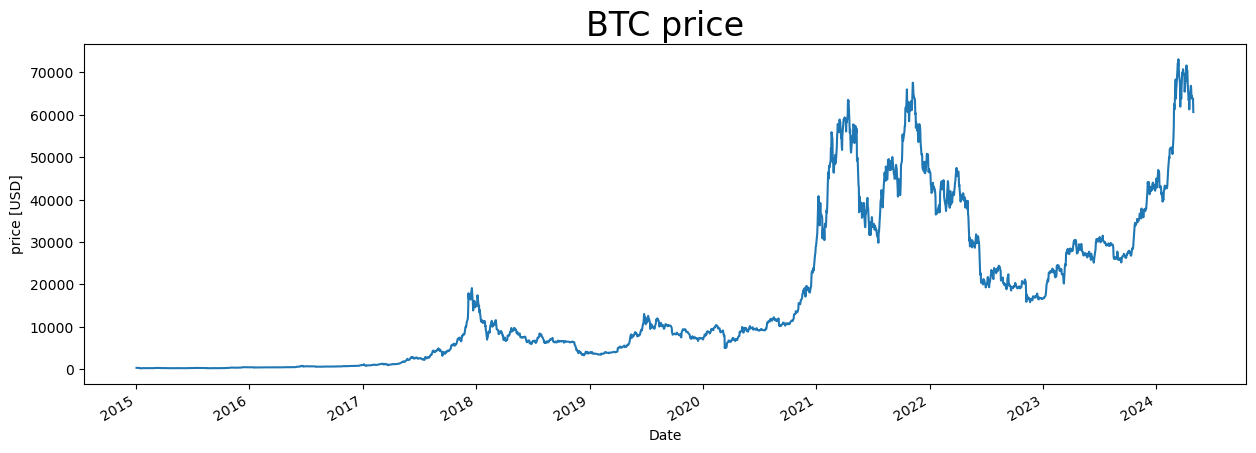

In [46]:
ax = btc_close.price.plot(figsize=(15,5))
ax.set_ylabel('price [USD]')
plt.title('BTC price',fontsize=24)

Text(0.5, 1.0, 'EUR price')

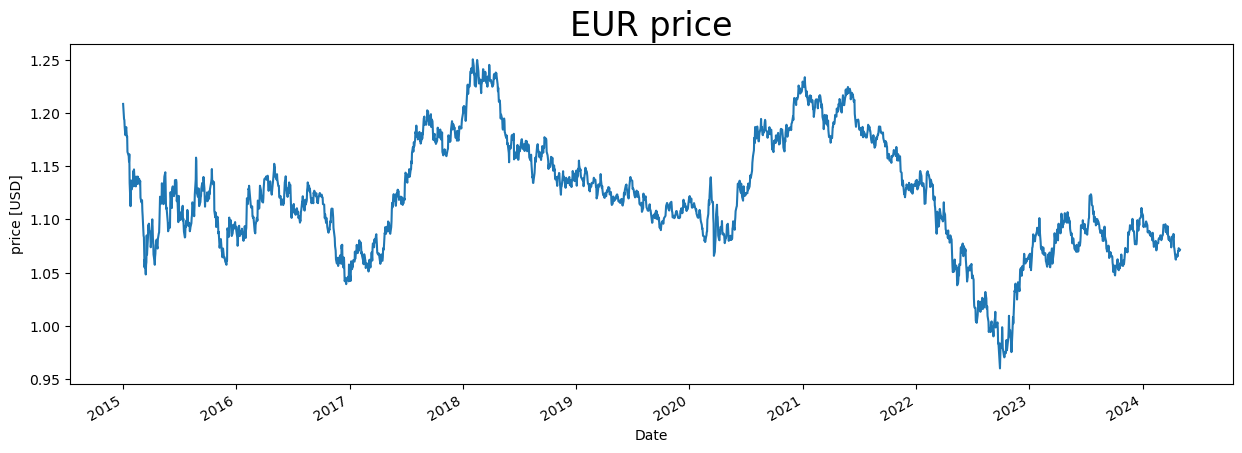

In [47]:
ax = eur_close.price.plot(figsize=(15,5))
ax.set_ylabel('price [USD]')
plt.title('EUR price',fontsize=24)

Text(0.5, 1.0, 'Gold price')

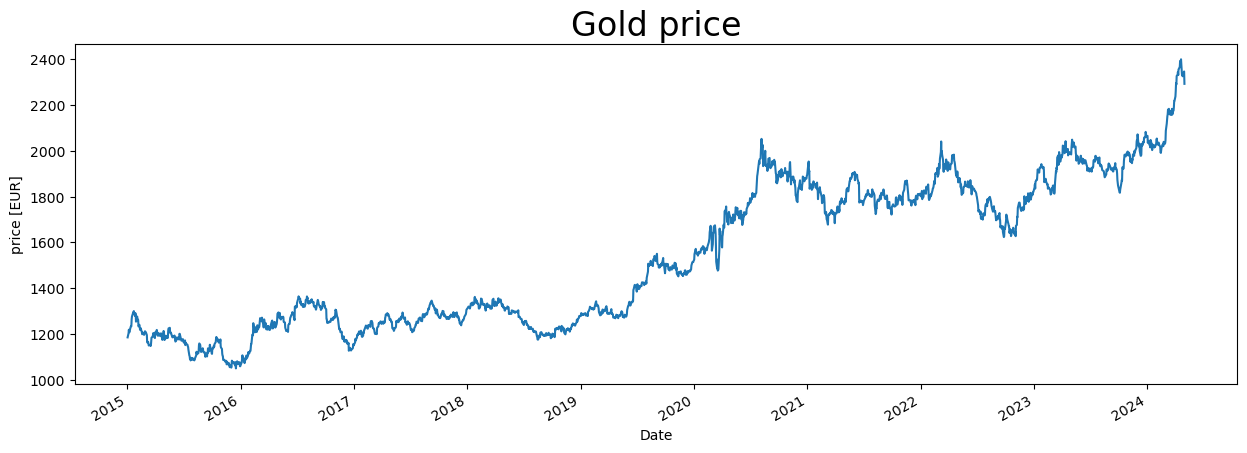

In [48]:
ax = gold_close.price.plot(figsize=(15,5))
ax.set_ylabel('price [EUR]')
plt.title('Gold price',fontsize=24)

The three plots display the fluctuating behavior of Bitcoin (BTC), the Euro (EUR) and of Gold fairly well. Recall that we use the US Dollar (USD) as a baseline.

In order to get a better feel of the stability, i.e. of the fluctuating behavior of the prices, we normalise each one according to their maximum and display them all in one plot for better comparison.

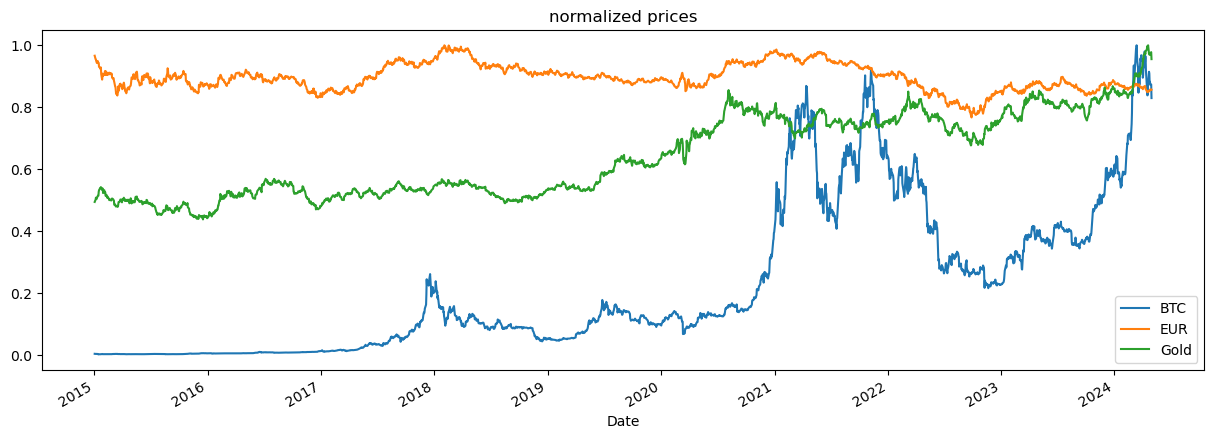

In [49]:
# NORMALIZED (BY MAX) PRICES
fig = plt.figure(figsize=(15,5))
btc_close.price.div(btc_close.price.max()).plot(label='BTC')
eur_close.price.div(eur_close.price.max()).plot(label='EUR')
gold_close.price.div(gold_close.price.max()).plot(label='Gold')

plt.title('normalized prices')
plt.legend()

As one might have expected from experience, the largest fluctuations seem to be inherent to Bitcoin, while the Euro price seems to be farily stable.

### Returns

Returns tend to be more stable than prices, so let's have a look at the returns.

Text(0.5, 1.0, 'returns')

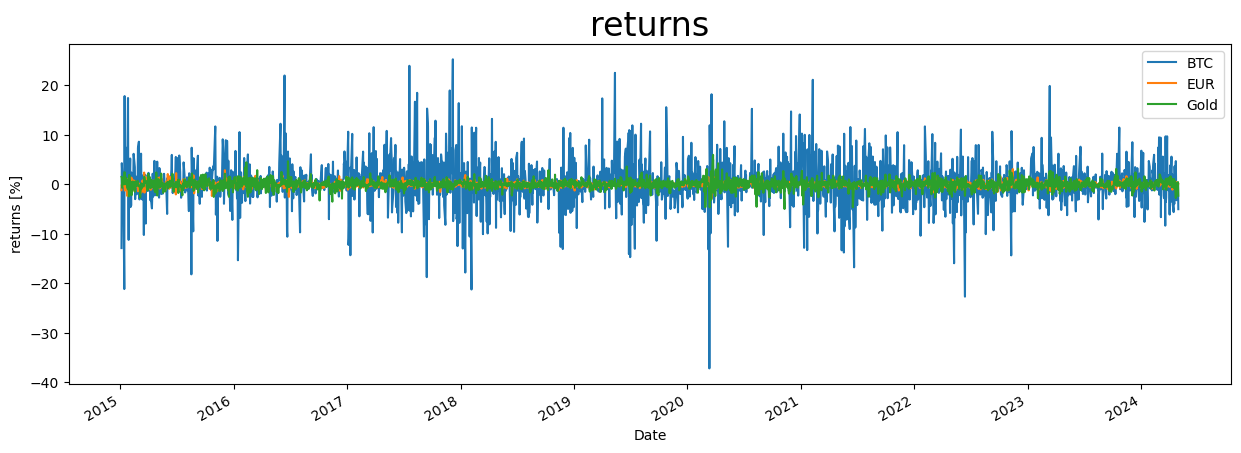

In [50]:
fig, ax = plt.subplots(figsize=(15,5))
btc_close.returns[1:].mul(100).plot(figsize=(15,5),label='BTC')
eur_close.returns[1:].mul(100).plot(figsize=(15,5),label='EUR')
gold_close.returns[1:].mul(100).plot(figsize=(15,5),label='Gold')
ax.set_ylabel('returns [%]')
plt.legend()
plt.title('returns',fontsize=24)

We observe the same behavior as for the prices; the returns of Bitcoin fluctauate the most.
In fact, the Bitcoin returns fluctuate heavily, with up to 20%.

## Timeseries Analysis

After we have explored briefly the prices and returns, we are now ready to start with our analysis.

We start by examining the stationarity of our data.

### Stationarity

#### Bitcoin

Let us start with examining the ACF and PACF plots of the price and returns of Bitcoin

Text(0.5, 1.0, 'PACF BTC price')

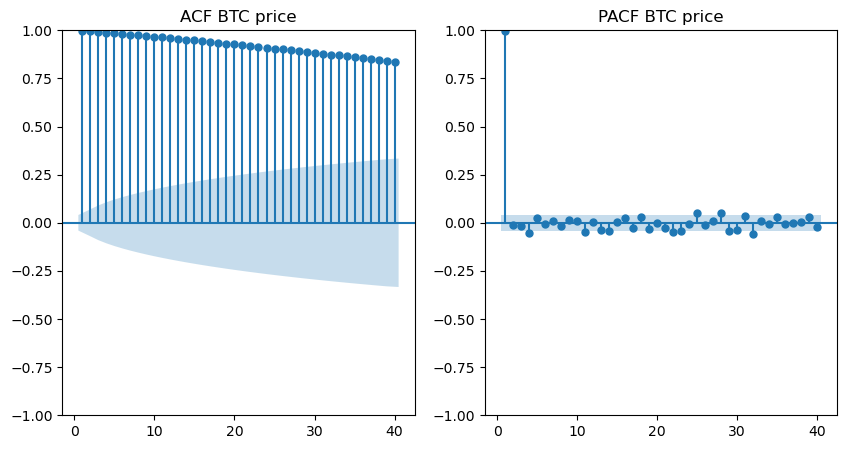

In [51]:
# (P)ACF BTC PRICES
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

sgt.plot_acf(btc_close.price,ax=ax[0],lags = 40, zero=False)
ax[0].set_title('ACF BTC price')
sgt.plot_pacf(btc_close.price,ax=ax[1],lags= 40, zero=False)
ax[1].set_title('PACF BTC price')


Text(0.5, 1.0, 'PACF BTC returns')

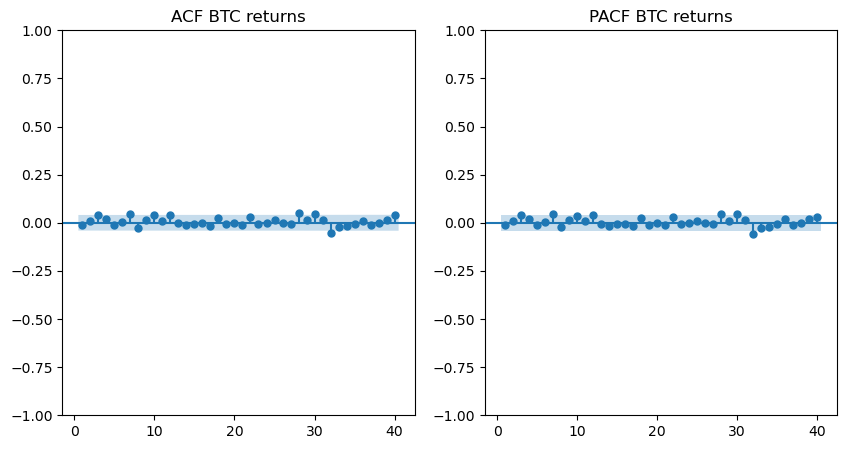

In [52]:
# (P)ACF BTC RETURNS
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sgt.plot_acf(btc_close.returns[1:],ax=ax[0],lags = 40, zero=False)
ax[0].set_title('ACF BTC returns')
sgt.plot_pacf(btc_close.returns[1:],ax=ax[1],lags = 40, zero=False)
ax[1].set_title('PACF BTC returns')

The (P)ACF plots suggest that, as expected, the *price* unlike the *returns* is not stationary.
There are several significant lags.

However, having a closer look at the ACF and PACF plot of the price we see that only the *first* lag seems to be significant (c.f. the PACF plot). 
This is a typical behavior of financial data - the price today is mostly determined by the price yesterday.

As a final test for stationarity, let us look at the Dickey-Fuller criterion for price and returns.


In [53]:
sts.adfuller(btc_close.returns[1:]) # => STATIONARY

(-48.87314499147138,
 0.0,
 0,
 2336,
 {'1%': -3.4331524402158027,
  '5%': -2.862778064998932,
  '10%': -2.567429076405341},
 -7932.5643849396)

As we can observe, the *p-value* (second entry) of returns is close to zero; additionally the value (first entry) is much smaller than the critical value for the 1%, 5% and 10% confidence intervals and hence we can deduce that **returns** are indeed **stationary**.

In [54]:
sts.adfuller(btc_close.price) # => NON-STATIONARY

(-1.1183124620865013,
 0.7077141343309564,
 24,
 2313,
 {'1%': -3.433180338127563,
  '5%': -2.862790383920141,
  '10%': -2.5674356352962047},
 38576.51155577872)

On the other handn, when we look at prices, we see that the p-value is only 0.12 which is larger than the 0.05 threshold.
In addition the actual value is in fact greater than the critical values for the 1%, 5% and 10% confidence intervals and hence we can assume that the **price** is **non-stationary**.

#### EUR

For the Euro, we find the same results.

Text(0.5, 1.0, 'PACF EUR price')

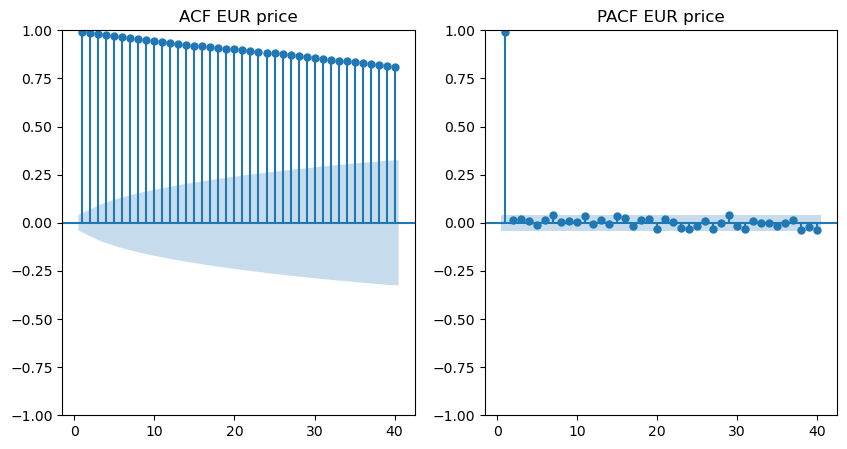

In [55]:
# (P)ACF USCD PRICES
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

sgt.plot_acf(eur_close.price,ax=ax[0],lags = 40, zero=False)
ax[0].set_title('ACF EUR price')
sgt.plot_pacf(eur_close.price,ax=ax[1],lags= 40, zero=False)
ax[1].set_title('PACF EUR price')

Text(0.5, 1.0, 'PACF EUR returns')

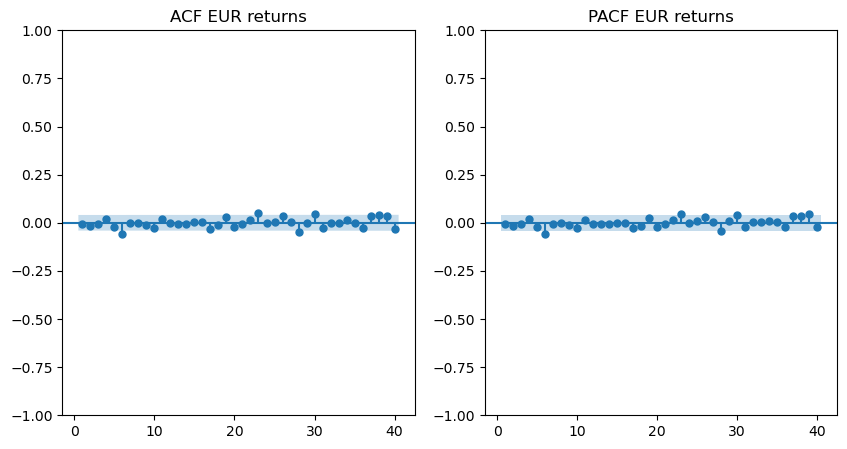

In [56]:
# (P)ACF USCD RETURNS
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sgt.plot_acf(eur_close.returns[1:],ax=ax[0],lags = 40, zero=False)
ax[0].set_title('ACF EUR returns')
sgt.plot_pacf(eur_close.returns[1:],ax=ax[1],lags = 40, zero=False)
ax[1].set_title('PACF EUR returns')

In [57]:
# DICKEY-FULLER TEST EUR RETURNS
sts.adfuller(eur_close.returns[1:]) # => STATIONARY

(-21.3032951409186,
 0.0,
 5,
 2331,
 {'1%': -3.4331584580953063,
  '5%': -2.862780722332404,
  '10%': -2.567430491232177},
 -17821.655082550595)

In [58]:
# DICKEY-FULLER TEST USCD PRICE
sts.adfuller(eur_close.price) # => NON-STATIONARY

(-2.8004003721422617,
 0.05821660051321182,
 0,
 2337,
 {'1%': -3.4331512397333626,
  '5%': -2.8627775348975866,
  '10%': -2.567428794167024},
 -17363.33630627702)

#### Gold

As before, we find the same results: returns are stationary, prices are not.

Text(0.5, 1.0, 'PACF Gold price')

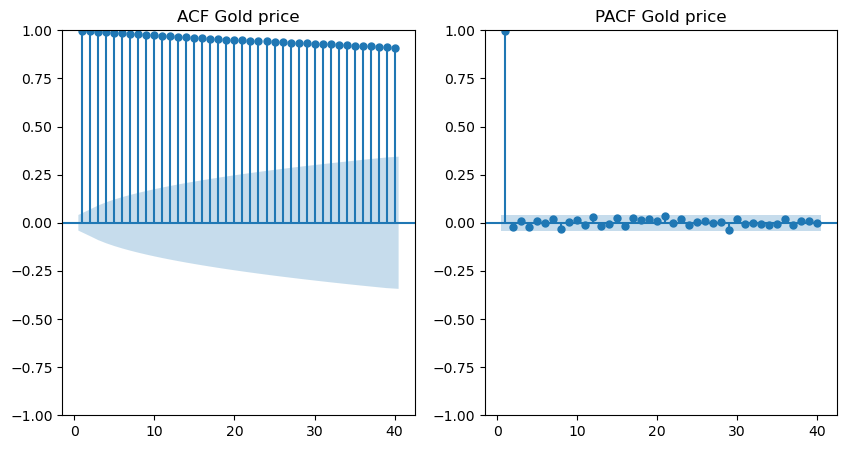

In [59]:
# (P)ACF PLOTS PRICES
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

sgt.plot_acf(gold_close.price,ax=ax[0],lags = 40, zero=False)
ax[0].set_title('ACF Gold price')
sgt.plot_pacf(gold_close.price,ax=ax[1],lags= 40, zero=False)
ax[1].set_title('PACF Gold price')

Text(0.5, 1.0, 'PACF Gold returns')

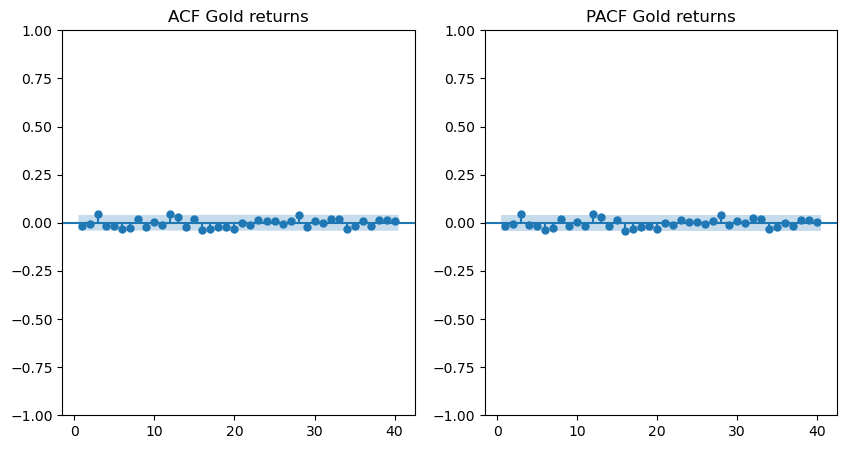

In [60]:
# (P)ACF PLOTS PRICES
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

sgt.plot_acf(gold_close.returns[1:],ax=ax[0],lags = 40, zero=False)
ax[0].set_title('ACF Gold returns')
sgt.plot_pacf(gold_close.returns[1:],ax=ax[1],lags= 40, zero=False)
ax[1].set_title('PACF Gold returns')

In [61]:
# DICKEY-FULLER TEST GOLD RETURNS
sts.adfuller(gold_close.returns[1:]) # => STATIONARY

(-49.18533445681854,
 0.0,
 0,
 2336,
 {'1%': -3.4331524402158027,
  '5%': -2.862778064998932,
  '10%': -2.567429076405341},
 -15118.28355257796)

In [62]:
# DICKEY-FULLER TEST GOLD PRICE
sts.adfuller(gold_close.price) # => NON-STATIONARY

(0.05613700692296396,
 0.9629355807208685,
 6,
 2331,
 {'1%': -3.4331584580953063,
  '5%': -2.862780722332404,
  '10%': -2.567430491232177},
 19006.41984502496)

## Gold as a Benchmark

Before we turn our attention to the Bitcoin data, we want to analyse first the **gold** price and returns, since historically gold was taken as a benchmark currency. 
We therefore expect that the gold market to be rather stable, i.e. that it enjoys low volatility.

### Splitting the data set

In [63]:
# GOLD RETURNS
gold_ret = gold_close.returns[1:]


Let us quickly test if the returns `gold_ret` are stationary (Dickey-Fuller test).

In [64]:
print(f'mean gold_ret: {gold_ret.describe().iloc[1]}')
print(f'std gold_ret: {gold_ret.describe().iloc[2]}')
print('')
print('Dickey-Fuller Test:')
sts.adfuller(gold_ret)

mean gold_ret: 0.00032402961886497607
std gold_ret: 0.009187859858814387

Dickey-Fuller Test:


(-49.18533445681854,
 0.0,
 0,
 2336,
 {'1%': -3.4331524402158027,
  '5%': -2.862778064998932,
  '10%': -2.567429076405341},
 -15118.28355257796)

Let us also quickly check for missing values.

In [65]:
print(f'missing values gold_ret_std: {gold_ret.isna().sum()}')

missing values gold_ret_std: 0


We continue with splitting the data set.
We will choose 80% of the data for the training set and the remaining 20% for the test set.

In [67]:
cut_off = int(0.8*len(gold_ret))

gold_ret_train = gold_ret.iloc[:cut_off]
gold_ret_test = gold_ret.iloc[cut_off:]

### GARCH(1,1)-model to analyze volatility 

To analyze the volatitliy of the standardized gold returns, we define a GARCH(1,1)model.

In [68]:
# DEFINE START (LAST OBSERVATION) AND END DATE 

last_obs = gold_ret_train.index[-1] # Last observed date of the training set
start = gold_ret_test.index[0] # Start date for forcasting
end = gold_ret_test.index[-1] # End date for forecasting

We start with a GARCH model assuming a normal distribution of the residuals.

In [69]:
# FITTING A GARCH(1,1) MODEL 
gold_ret_model = arch_model(gold_ret,mean='constant',vol='GARCH',p=1,q=1,dist='normal') 
results = gold_ret_model.fit(last_obs=last_obs,update_freq=5) 

Iteration:      5,   Func. Count:     61,   Neg. LLF: -6164.818956389199
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6164.818950228186
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 5


/Users/youmans/anaconda3/envs/IBM_ds/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.69e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [70]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6164.82
Distribution:                  Normal   AIC:                          -12321.6
Method:            Maximum Likelihood   BIC:                          -12299.5
                                        No. Observations:                 1868
Date:                Mon, May 27 2024   Df Residuals:                     1867
Time:                        20:13:15   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6954e-04  1.664e-05     10.188  2.245e-24 [1.369e-04,2.022e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.7380e-06  4.675e-11  3.717e+04      0.000 [1.738e-06,1.738e-06]
alpha[1]       0.0500  1.564e-02      3.198  1.385e-03 [1.935e-02,8.065e-02]
beta[1]        0.9300  1.381e-02     67.332      0.000     [  0.903,  0.957]
============================================================================

Covariance estimator: robust
"""

For diagnostic purposes, we will study the *standardized* returns.
They are calculated by dividing the raw returns by the estimated conditional standard deviations.

Ideally, the standardized returns exhibit properties of white noise, i.e. they have 
* zero mean 
* constannt variance 
* no significant auto-correlation coefficients

To test these assumptions we will use the `describe()` method and analyze the ACF and PACF plots.

In [71]:
pred_mu = results.params.iloc[0]
pred_std = results.conditional_volatility
gold_std_ret = (gold_ret
    .sub(pred_mu)
    .div(pred_std)
    )

In [72]:
gold_std_ret.isna().sum()

469

We observe that a large amount of data is missing.
For the time being, we will postpone the analysis of the missing data and focus on the data present.
However, this is to be expected since we have stopped the fitting process after the last observation.

Indeed, if we study which dates have missing values we observe that they start with the day we stopped fitting our model:

In [73]:
# LAST OBSERVATION
print(f'last observation: {last_obs}\n')

# MISSING VALUES OF RESIDUALS
print('Missing values of residuals:')
print(gold_std_ret[gold_std_ret.isna()].head())

last observation: 2022-06-15 00:00:00

Missing values of residuals:
Date
2022-06-15   NaN
2022-06-16   NaN
2022-06-17   NaN
2022-06-21   NaN
2022-06-22   NaN
Freq: C, dtype: float64


We therefore may just drop the missing values.

In [74]:
gold_std_ret = gold_std_ret.dropna()

<Axes: title={'center': 'Gold standardized returns'}, xlabel='Date'>

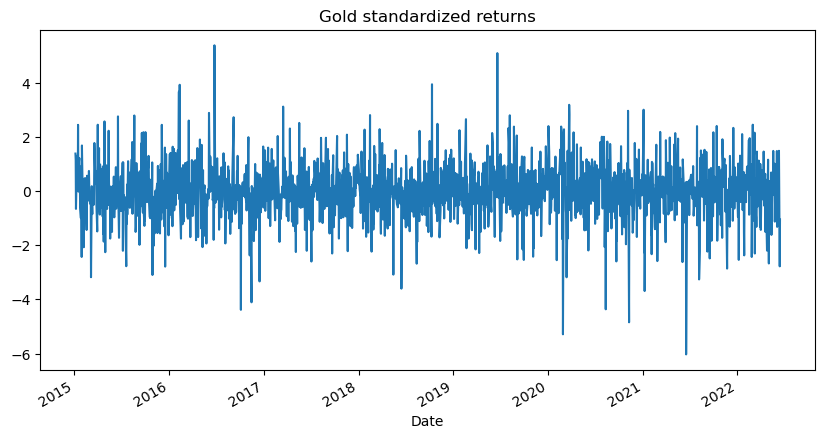

In [75]:
gold_std_ret.plot(title='Gold standardized returns',figsize=(10,5))

In [76]:
gold_std_ret.describe()

count    1868.000000
mean        0.011716
std         1.007857
min        -6.032064
25%        -0.498000
50%         0.017771
75%         0.556585
max         5.380156
dtype: float64

Text(0.5, 1.0, 'PACF for Gold std. returns')

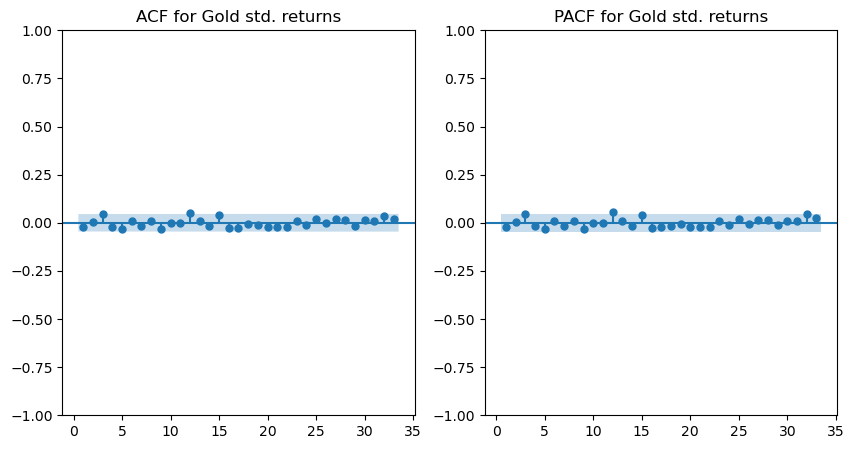

In [77]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=((10,5)))

sgt.plot_acf(gold_std_ret,ax=ax[0],zero=False)
ax[0].set_title('ACF for Gold std. returns')
sgt.plot_pacf(gold_std_ret,ax=ax[1],zero=False)
ax[1].set_title('PACF for Gold std. returns')

In first approximation, we may assume that the standardized returns are indeed white noise, which indicate that the model is well-specified.

### Forecasting

In [78]:
# FORECAST THE CONDITIONAL VARIANCE FOR TEST PERIOD
predictions = results.forecast(horizon=1,align='target',start=start)
pred_var = predictions.residual_variance[start:end]
pred_var = pred_var.rename(columns={'h.1':'pred_var'})

gold_ret_test_var = gold_ret_test**2



Text(0.5, 1.0, 'Volatility Prediction')

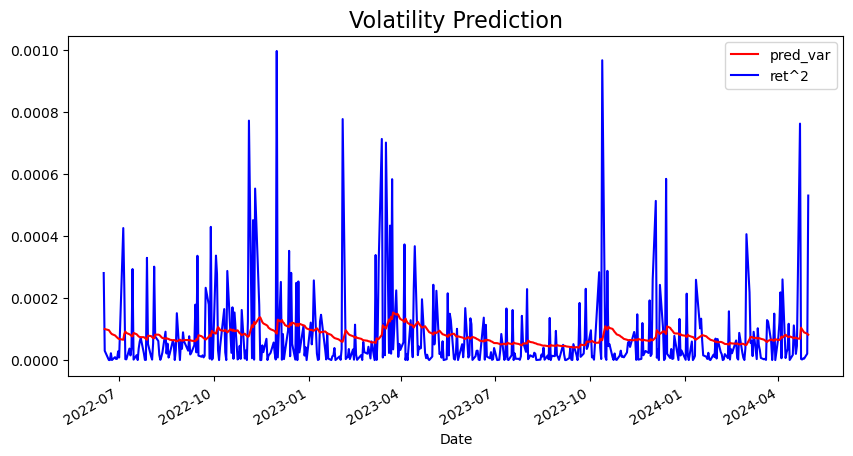

In [79]:
pred_var.plot(color='red', zorder=1,figsize=(10,5))
gold_ret_test_var.plot(color='blue',label='ret^2',zorder=0)
plt.legend()
plt.title('Volatility Prediction',fontsize=16)

When looking at the volatility prediction graphs, we can conclude that the GARCH(1,1) model, assuming a *normal*-distribution of the errors, captures the trend of the squared returns fairly well.
In particular, we are able to see the clustering effects: periods of high/low volatility follow perieds of high/low volatility.

However the model falls short in determining the magnitude of the variance. 

Below, we will see that this shortcoming can be overcome by a GARCH model assuming a *t*-distribution of the error terms.

In [80]:
# FITTING A GARCH(1,1) MODEL 
gold_ret_model_t = arch_model(gold_close.returns[1:],mean='constant',vol='GARCH',p=1,q=1,dist='t') 
results_t = gold_ret_model_t.fit(last_obs=last_obs,update_freq=5) 

Iteration:      5,   Func. Count:     54,   Neg. LLF: 20793.388749922415
Iteration:     10,   Func. Count:     86,   Neg. LLF: 11144.278657447503
Iteration:     15,   Func. Count:    132,   Neg. LLF: 51475.1733075926
Iteration:     20,   Func. Count:    199,   Neg. LLF: 26320.583442093197
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5331.8222572554205
            Iterations: 25
            Function evaluations: 210
            Gradient evaluations: 21


/Users/youmans/anaconda3/envs/IBM_ds/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.69e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [81]:
results_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                5331.82
Distribution:      Standardized Student's t   AIC:                          -10653.6
Method:                  Maximum Likelihood   BIC:                          -10626.0
                                              No. Observations:                 1868
Date:                      Mon, May 27 2024   Df Residuals:                     1867
Time:                              20:14:03   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.7238e-04  1.570e-04      1.735  8.282e-02 [-3.540e-05,5.802e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.2604e-04  2.261e-05     32.116 2.594e-226 [6.817e-04,7.704e-04]
alpha[1]       0.8068      0.291      2.774  5.539e-03     [  0.237,  1.377]
beta[1]        0.1929  1.133e-02     17.018  6.042e-65     [  0.171,  0.215]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.0765  1.161e-02    264.899      0.000 [  3.054,  3.099]
========================================================================

Covariance estimator: robust
"""

In [82]:
predictions_t= results_t.forecast(horizon=1,align='target',start=start)
pred_var_t = predictions_t.variance[start:end]
pred_var_t = pred_var_t.rename(columns={'h.1':'pred_var'})

Text(0.5, 1.0, 'Volatility Prediction')

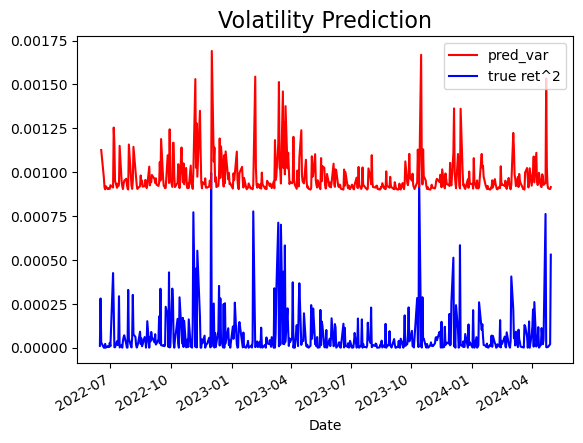

In [84]:
pred_var_t.plot(color='red', zorder=1)
gold_close.returns[cut_off:].mul(gold_close.returns[cut_off:]).plot(color='blue',label='true ret^2',zorder=0)
plt.legend()
plt.title('Volatility Prediction',fontsize=16)

The above volatility plot looks like up to a constant off-set, the model captures the volatility of gold extremely well!

Let us corret for the constant off-set by subtracting the minimial value of the predicted volatility.

Text(0.5, 1.0, '(corrected) Volatility Prediction')

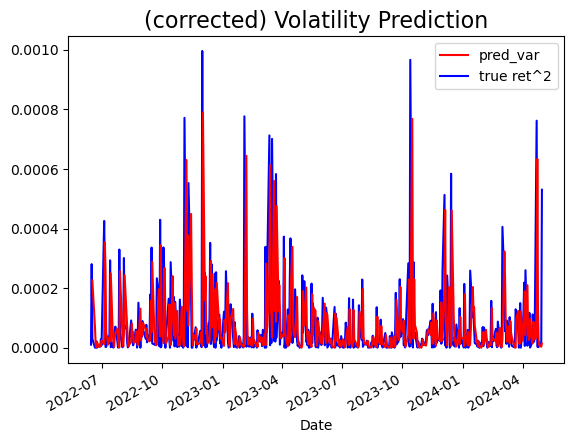

In [85]:
# CORRECT OFFSET BY SUBTRACTING MIN OF PREDICTED VOLATILITY
pred_var_t.sub(pred_var_t.min()).plot(color='red', zorder=1)
gold_close.returns[cut_off:].mul(gold_close.returns[cut_off:]).plot(color='blue',label='true ret^2',zorder=0)
plt.legend()
plt.title('(corrected) Volatility Prediction',fontsize=16)

Finally, let us remark that the order of magnitude of the volatility is $10^{-3}$, and hence very small. 
This confirms that gold returns are very stable and thus serve well as benchmark returns.